In [1]:
%matplotlib inline
import pandas as pd
import glob
import yaml
import numpy as np

from matplotlib import pyplot as plt

In [2]:
def strategy_alias(strategy):
    if strategy[:3] == "alt":
        return "algo2/k:" + strategy.split("/")[1].split("|")[0].split(":")[1]
    elif strategy[:3] == "seq":
        return strategy.replace("seq", "algo1")
    else:
        return strategy

In [3]:
def read_salt_pepper_analysis(path):
    with open(f"{path}/salt-pepper-analysis.yml", "r") as fh:
        result = yaml.safe_load(fh)
    with open(f"{path}/summary.yml", "r") as fh:
        summary = yaml.safe_load(fh)
        summary["strategy"] = strategy_alias(summary["strategy"])
    return summary, result

read_salt_pepper_analysis("../artifacts-server/mpg-server/experiment-mnist-256d-test-robustness/mnist-various-opts-M1/vdb-mnist--2019-12-19--02-39-59-799025")

({'M': 1,
  'beta': 0.001,
  'dataset': 'mnist',
  'epoch': 200,
  'lr': 0.0001,
  'metrics': {'test': {'I_XZ': 27.33572769165039,
    'I_YZ': 3.196556806564331,
    'accuracy_L1': 0.9815000295639038,
    'accuracy_L12': 0.9851998686790466,
    'loss': 0.152706578373909},
   'train': {'I_XZ': 26.814111709594727,
    'I_YZ': 3.314906358718872,
    'accuracy_L1': 0.9996497631072998,
    'accuracy_L12': 1.0,
    'loss': 0.03383512794971466}},
  'model': 'vdb/e1:1024|e2:1024|z:256',
  'strategy': 'algo1/d:10|e:1'},
 {'L': 12,
  'batch_size': 1000,
  'settings': [{'accuracy': 0.9845999479293823, 'p': 0},
   {'accuracy': 0.9753000140190125, 'p': 0.1},
   {'accuracy': 0.9429000616073608, 'p': 0.2},
   {'accuracy': 0.7723000049591064, 'p': 0.3},
   {'accuracy': 0.41780003905296326, 'p': 0.4},
   {'accuracy': 0.12560001015663147, 'p': 0.5}]})

In [7]:
def read_analysis_from_dir(model_dir):
    models = list(map(lambda x: "/".join(x.split("/")[:-1]), glob.glob(f"{model_dir}/salt-pepper-analysis.yml")))
    print(f"we have {len(models)} analyses")
    
    data = []
    for m in models:
        summary, result = read_salt_pepper_analysis(m)
        for r in result['settings']:
            data.append(
                dict(
                    strategy=summary['strategy'],
                    M=summary['M'],
                    **r
                )
            )
    return pd.DataFrame(data)

In [8]:
def print_table(df, p, L, should_print=True):
    metric = "accuracy"
    df = df[(df.p == p) & (df.L == L)]\
        .groupby(["strategy", "M"])[metric]\
        .agg({metric: ['mean', 'std']})\
        .reset_index()
        
    df["temp"] = df[metric][['mean', 'std']].apply(lambda x: "%.2f±%.4f\%%" % (x[0]*100, x[1]*100), axis=1) 

    df = df.drop(columns=[metric])\
        .rename(columns={"temp": f"{metric} ($p=%f$, L=%d)" % (p, L)}) \
        .pivot(index="strategy", columns="M")
    
    if should_print:
        print(df.to_latex(column_format="rcccc", escape=False))
    
    return df

# MNIST
## VDB 256

In [9]:
df_mnist_256d = read_analysis_from_dir("../artifacts-server/hydra/experiment-mnist-256d-test-robustness/*/*")
df_mnist_256d.groupby(["strategy", "M", "L", "p"])["M"].count()

we have 112 analyses


strategy        M   L   p  
algo1/d:10|e:1  1   1   0.0    4
                        0.1    4
                        0.2    4
                        0.3    4
                        0.4    4
                        0.5    4
                    12  0.0    4
                        0.1    4
                        0.2    4
                        0.3    4
                        0.4    4
                        0.5    4
                6   1   0.0    4
                        0.1    4
                        0.2    4
                        0.3    4
                        0.4    4
                        0.5    4
                    12  0.0    4
                        0.1    4
                        0.2    4
                        0.3    4
                        0.4    4
                        0.5    4
                12  1   0.0    4
                        0.1    4
                        0.2    4
                        0.3    4
                        0.4    4
               

In [227]:
print_table(df_mnist_256d, 0.0, 12, should_print=True)

\begin{tabular}{rcccc}
\toprule
{} & \multicolumn{4}{l}{accuracy ($p=0.000000$, L=12)} \\
{} \\
M &                            1  &              6  &              12 &              18 \\
strategy       &                               &                 &                 &                 \\
\midrule
algo1/d:10|e:1 &                98.51±0.0457\% &  98.58±0.0602\% &  98.66±0.0967\% &  98.61±0.0300\% \\
algo1/d:20|e:1 &                98.61±0.1352\% &  98.57±0.0299\% &  98.66±0.0589\% &  98.60±0.0294\% \\
algo1/d:5|e:1  &                98.48±0.1804\% &  98.61±0.0638\% &  98.50±0.1846\% &  98.66±0.0938\% \\
algo2/k:10     &                98.60±0.0939\% &  98.61±0.0557\% &  98.69±0.0802\% &  98.63±0.0469\% \\
algo2/k:20     &                98.56±0.1866\% &  98.64±0.1050\% &  98.62±0.0976\% &  98.65±0.0737\% \\
algo2/k:5      &                98.45±0.0550\% &  98.44±0.3968\% &  98.59±0.0545\% &  98.57±0.0716\% \\
oneshot        &                98.47±0.2004\% &  98.62±0.0705\% &  98.64±0.

/Users/heytitle/projects/venv-python3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


accuracy ($p=0.000000$, L=12)                                  \
                                                                               
M                                         1               6               12   
strategy                                                                       
algo1/d:10|e:1                98.51±0.0457\%  98.58±0.0602\%  98.66±0.0967\%   
algo1/d:20|e:1                98.61±0.1352\%  98.57±0.0299\%  98.66±0.0589\%   
algo1/d:5|e:1                 98.48±0.1804\%  98.61±0.0638\%  98.50±0.1846\%   
algo2/k:10                    98.60±0.0939\%  98.61±0.0557\%  98.69±0.0802\%   
algo2/k:20                    98.56±0.1866\%  98.64±0.1050\%  98.62±0.0976\%   
algo2/k:5                     98.45±0.0550\%  98.44±0.3968\%  98.59±0.0545\%   
oneshot                       98.47±0.2004\%  98.62±0.0705\%  98.64±0.0714\%   

                                
                                
M                           18  
strategy                        
algo1/d:10|e:1  98.61±0.0300\%  
algo1/d:20|e:1  98.60±0.0294\%  
algo1/d:5|e:1   98.66±0.0938\%  
algo2/k:10      98.63±0.0469\%  
algo2/k:20      98.65±0.0737\%  
algo2/k:5       98.57±0.0716\%  
oneshot         98.62±0.0676\%

In [228]:
print_table(df_mnist_256d, 0.1, 12, should_print=True)

\begin{tabular}{rcccc}
\toprule
{} & \multicolumn{4}{l}{accuracy ($p=0.100000$, L=12)} \\
{} \\
M &                            1  &              6  &              12 &              18 \\
strategy       &                               &                 &                 &                 \\
\midrule
algo1/d:10|e:1 &                97.66±0.1410\% &  97.87±0.0991\% &  97.93±0.0750\% &  97.83±0.0971\% \\
algo1/d:20|e:1 &                97.72±0.3248\% &  97.93±0.0770\% &  97.94±0.0939\% &  97.80±0.1162\% \\
algo1/d:5|e:1  &                97.53±0.2452\% &  97.90±0.0826\% &  97.68±0.3762\% &  97.89±0.0635\% \\
algo2/k:10     &                97.71±0.2667\% &  97.90±0.1282\% &  97.88±0.1127\% &  97.87±0.0914\% \\
algo2/k:20     &                97.63±0.2488\% &  97.92±0.0846\% &  97.92±0.0666\% &  97.90±0.0556\% \\
algo2/k:5      &                97.48±0.1410\% &  97.65±0.6291\% &  97.84±0.0632\% &  97.82±0.1993\% \\
oneshot        &                97.38±0.2865\% &  97.87±0.0898\% &  97.92±0.

/Users/heytitle/projects/venv-python3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


accuracy ($p=0.100000$, L=12)                                  \
                                                                               
M                                         1               6               12   
strategy                                                                       
algo1/d:10|e:1                97.66±0.1410\%  97.87±0.0991\%  97.93±0.0750\%   
algo1/d:20|e:1                97.72±0.3248\%  97.93±0.0770\%  97.94±0.0939\%   
algo1/d:5|e:1                 97.53±0.2452\%  97.90±0.0826\%  97.68±0.3762\%   
algo2/k:10                    97.71±0.2667\%  97.90±0.1282\%  97.88±0.1127\%   
algo2/k:20                    97.63±0.2488\%  97.92±0.0846\%  97.92±0.0666\%   
algo2/k:5                     97.48±0.1410\%  97.65±0.6291\%  97.84±0.0632\%   
oneshot                       97.38±0.2865\%  97.87±0.0898\%  97.92±0.1247\%   

                                
                                
M                           18  
strategy                        
algo1/d:10|e:1  97.83±0.0971\%  
algo1/d:20|e:1  97.80±0.1162\%  
algo1/d:5|e:1   97.89±0.0635\%  
algo2/k:10      97.87±0.0914\%  
algo2/k:20      97.90±0.0556\%  
algo2/k:5       97.82±0.1993\%  
oneshot         97.86±0.1059\%

In [229]:
print_table(df_mnist_256d, 0.2, 12, should_print=True)

\begin{tabular}{rcccc}
\toprule
{} & \multicolumn{4}{l}{accuracy ($p=0.200000$, L=12)} \\
{} \\
M &                            1  &              6  &              12 &              18 \\
strategy       &                               &                 &                 &                 \\
\midrule
algo1/d:10|e:1 &                93.88±0.6636\% &  95.60±0.1718\% &  95.86±0.0829\% &  95.79±0.0998\% \\
algo1/d:20|e:1 &                94.49±1.4410\% &  95.76±0.2343\% &  95.76±0.2345\% &  95.80±0.1934\% \\
algo1/d:5|e:1  &                92.36±1.5312\% &  95.72±0.2910\% &  95.67±0.4224\% &  95.73±0.1767\% \\
algo2/k:10     &                94.38±0.1748\% &  95.77±0.1896\% &  95.88±0.0387\% &  95.69±0.1619\% \\
algo2/k:20     &                94.79±0.9512\% &  95.70±0.3777\% &  95.88±0.1103\% &  95.74±0.1167\% \\
algo2/k:5      &                93.08±0.7523\% &  95.46±0.7692\% &  95.46±0.1826\% &  95.39±0.3790\% \\
oneshot        &                90.31±1.5437\% &  95.43±0.1682\% &  95.70±0.

/Users/heytitle/projects/venv-python3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


accuracy ($p=0.200000$, L=12)                                  \
                                                                               
M                                         1               6               12   
strategy                                                                       
algo1/d:10|e:1                93.88±0.6636\%  95.60±0.1718\%  95.86±0.0829\%   
algo1/d:20|e:1                94.49±1.4410\%  95.76±0.2343\%  95.76±0.2345\%   
algo1/d:5|e:1                 92.36±1.5312\%  95.72±0.2910\%  95.67±0.4224\%   
algo2/k:10                    94.38±0.1748\%  95.77±0.1896\%  95.88±0.0387\%   
algo2/k:20                    94.79±0.9512\%  95.70±0.3777\%  95.88±0.1103\%   
algo2/k:5                     93.08±0.7523\%  95.46±0.7692\%  95.46±0.1826\%   
oneshot                       90.31±1.5437\%  95.43±0.1682\%  95.70±0.1987\%   

                                
                                
M                           18  
strategy                        
algo1/d:10|e:1  95.79±0.0998\%  
algo1/d:20|e:1  95.80±0.1934\%  
algo1/d:5|e:1   95.73±0.1767\%  
algo2/k:10      95.69±0.1619\%  
algo2/k:20      95.74±0.1167\%  
algo2/k:5       95.39±0.3790\%  
oneshot         95.86±0.1932\%

In [230]:
print_table(df_mnist_256d, 0.3, 12, should_print=True)

\begin{tabular}{rcccc}
\toprule
{} & \multicolumn{4}{l}{accuracy ($p=0.300000$, L=12)} \\
{} \\
M &                            1  &              6  &              12 &              18 \\
strategy       &                               &                 &                 &                 \\
\midrule
algo1/d:10|e:1 &                75.61±3.2905\% &  89.47±0.8681\% &  90.46±0.5447\% &  90.31±0.1318\% \\
algo1/d:20|e:1 &                79.09±3.7706\% &  90.37±0.6231\% &  90.59±0.3445\% &  90.38±0.5258\% \\
algo1/d:5|e:1  &                70.96±2.4284\% &  89.39±1.6737\% &  90.07±0.6111\% &  89.94±0.7981\% \\
algo2/k:10     &                78.70±1.7800\% &  89.65±0.5054\% &  90.34±0.1991\% &  89.88±0.2223\% \\
algo2/k:20     &                80.83±3.6172\% &  90.50±0.7927\% &  90.35±0.3703\% &  89.97±0.6871\% \\
algo2/k:5      &                73.70±1.3070\% &  89.80±0.5222\% &  89.30±0.6891\% &  89.47±1.0747\% \\
oneshot        &                64.24±3.2182\% &  87.98±0.9520\% &  90.09±0.

/Users/heytitle/projects/venv-python3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


accuracy ($p=0.300000$, L=12)                                  \
                                                                               
M                                         1               6               12   
strategy                                                                       
algo1/d:10|e:1                75.61±3.2905\%  89.47±0.8681\%  90.46±0.5447\%   
algo1/d:20|e:1                79.09±3.7706\%  90.37±0.6231\%  90.59±0.3445\%   
algo1/d:5|e:1                 70.96±2.4284\%  89.39±1.6737\%  90.07±0.6111\%   
algo2/k:10                    78.70±1.7800\%  89.65±0.5054\%  90.34±0.1991\%   
algo2/k:20                    80.83±3.6172\%  90.50±0.7927\%  90.35±0.3703\%   
algo2/k:5                     73.70±1.3070\%  89.80±0.5222\%  89.30±0.6891\%   
oneshot                       64.24±3.2182\%  87.98±0.9520\%  90.09±0.6611\%   

                                
                                
M                           18  
strategy                        
algo1/d:10|e:1  90.31±0.1318\%  
algo1/d:20|e:1  90.38±0.5258\%  
algo1/d:5|e:1   89.94±0.7981\%  
algo2/k:10      89.88±0.2223\%  
algo2/k:20      89.97±0.6871\%  
algo2/k:5       89.47±1.0747\%  
oneshot         90.29±0.4951\%

In [225]:
print_table(df_mnist_256d, 0.4, 1, should_print=True)

\begin{tabular}{rcccc}
\toprule
{} & \multicolumn{4}{l}{accuracy ($p=0.400000$, L=1)} \\
{} \\
M &                           1  &              6  &              12 &              18 \\
strategy       &                              &                 &                 &                 \\
\midrule
algo1/d:10|e:1 &               38.56±3.7167\% &  70.60±2.0511\% &  74.44±1.6474\% &  76.28±1.2864\% \\
algo1/d:20|e:1 &               43.50±2.9746\% &  73.13±1.9117\% &  75.19±1.0348\% &  75.12±1.7061\% \\
algo1/d:5|e:1  &               34.03±2.6995\% &  68.79±5.0922\% &  74.59±2.4429\% &  74.29±2.2023\% \\
algo2/k:10     &               42.21±1.5783\% &  72.11±1.4990\% &  75.11±0.5831\% &  73.83±1.0685\% \\
algo2/k:20     &               48.61±4.0152\% &  75.28±2.1576\% &  76.22±0.8710\% &  75.65±1.3248\% \\
algo2/k:5      &               37.21±2.2783\% &  72.50±1.3014\% &  72.33±2.4064\% &  74.22±2.1828\% \\
oneshot        &               27.24±2.5717\% &  62.43±2.5090\% &  72.07±2.2197\% &  

/Users/heytitle/projects/venv-python3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


accuracy ($p=0.400000$, L=1)                                  \
                                                                              
M                                        1               6               12   
strategy                                                                      
algo1/d:10|e:1               38.56±3.7167\%  70.60±2.0511\%  74.44±1.6474\%   
algo1/d:20|e:1               43.50±2.9746\%  73.13±1.9117\%  75.19±1.0348\%   
algo1/d:5|e:1                34.03±2.6995\%  68.79±5.0922\%  74.59±2.4429\%   
algo2/k:10                   42.21±1.5783\%  72.11±1.4990\%  75.11±0.5831\%   
algo2/k:20                   48.61±4.0152\%  75.28±2.1576\%  76.22±0.8710\%   
algo2/k:5                    37.21±2.2783\%  72.50±1.3014\%  72.33±2.4064\%   
oneshot                      27.24±2.5717\%  62.43±2.5090\%  72.07±2.2197\%   

                                
                                
M                           18  
strategy                        
algo1/d:10|e:1  76.28±1.2864\%  
algo1/d:20|e:1  75.12±1.7061\%  
algo1/d:5|e:1   74.29±2.2023\%  
algo2/k:10      73.83±1.0685\%  
algo2/k:20      75.65±1.3248\%  
algo2/k:5       74.22±2.1828\%  
oneshot         73.58±2.4879\%

In [231]:
print_table(df_mnist_256d, 0.5, 12, should_print=True)

\begin{tabular}{rcccc}
\toprule
{} & \multicolumn{4}{l}{accuracy ($p=0.500000$, L=12)} \\
{} \\
M &                            1  &              6  &              12 &              18 \\
strategy       &                               &                 &                 &                 \\
\midrule
algo1/d:10|e:1 &                12.27±2.1190\% &  43.93±2.2062\% &  52.24±3.2353\% &  55.91±3.0151\% \\
algo1/d:20|e:1 &                15.40±1.6672\% &  48.59±3.5085\% &  53.94±1.6983\% &  54.85±2.7178\% \\
algo1/d:5|e:1  &                10.30±1.9303\% &  40.63±5.9596\% &  52.84±3.8992\% &  52.03±3.2690\% \\
algo2/k:10     &                14.31±1.1950\% &  47.82±2.8466\% &  54.55±0.8558\% &  53.40±0.9272\% \\
algo2/k:20     &                18.76±2.4607\% &  52.53±2.2533\% &  57.23±1.5065\% &  56.28±2.5747\% \\
algo2/k:5      &                12.69±1.2927\% &  47.16±3.8047\% &  50.20±3.3883\% &  53.70±2.9438\% \\
oneshot        &                 7.95±0.5463\% &  30.63±2.6428\% &  45.02±4.

/Users/heytitle/projects/venv-python3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


accuracy ($p=0.500000$, L=12)                                  \
                                                                               
M                                         1               6               12   
strategy                                                                       
algo1/d:10|e:1                12.27±2.1190\%  43.93±2.2062\%  52.24±3.2353\%   
algo1/d:20|e:1                15.40±1.6672\%  48.59±3.5085\%  53.94±1.6983\%   
algo1/d:5|e:1                 10.30±1.9303\%  40.63±5.9596\%  52.84±3.8992\%   
algo2/k:10                    14.31±1.1950\%  47.82±2.8466\%  54.55±0.8558\%   
algo2/k:20                    18.76±2.4607\%  52.53±2.2533\%  57.23±1.5065\%   
algo2/k:5                     12.69±1.2927\%  47.16±3.8047\%  50.20±3.3883\%   
oneshot                        7.95±0.5463\%  30.63±2.6428\%  45.02±4.5364\%   

                                
                                
M                           18  
strategy                        
algo1/d:10|e:1  55.91±3.0151\%  
algo1/d:20|e:1  54.85±2.7178\%  
algo1/d:5|e:1   52.03±3.2690\%  
algo2/k:10      53.40±0.9272\%  
algo2/k:20      56.28±2.5747\%  
algo2/k:5       53.70±2.9438\%  
oneshot         48.30±3.3765\%

## Plot Robustness Curve

In [19]:
import seaborn as sns

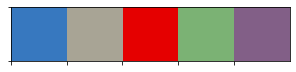

In [72]:
# sns.palplot(sns.cubehelix_palette(3, start=2, rot=0, dark=0, light=.60))
# sns.palplot(sns.cubehelix_palette(3, start=.5, rot=-.75, dark=0, light=.60))
colors = ["windows blue", "greyish", "red", "faded green", "dusty purple"]
sns.palplot(sns.xkcd_palette(colors))

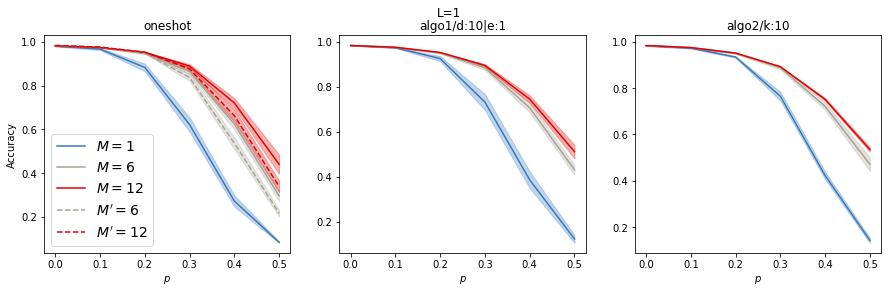

In [77]:
# cm = plt.get_cmap('tab10')
cm = sns.xkcd_palette(colors)
# cm = sns.cubehelix_palette(3, start=.5, rot=-.75, dark=0, light=.60)


def plot_robust_curve(df_main, L, strategies, M=[1, 6, 12], df_vib=None, alpha=0.3):
    plt.figure(figsize=(15, 4))
    total = len(strategies)
    color_indices = dict(zip(M, range(len(M))))
    for i, strategy in enumerate(strategies):
        plt.subplot(1, total, i+1)
        df =  df_main[ (df_main.strategy==strategy) & (df_main.L == L)].groupby(["M", "p"]) \
            .agg({"accuracy": ['mean', 'std']}).reset_index()


        for m in M:
            color = cm[color_indices[m]]

            df_ = df[df.M == m]
            mean, std = df_["accuracy"]["mean"].values, df_["accuracy"]["std"].values

            plt.plot(df_.p, mean, label=f"$M={m}$", color=color)
            plt.fill_between(df_.p, mean-std, mean+std, alpha=alpha, color=color)
            
        if strategy == "oneshot" and df_vib is not None:
            df =  df_vib[ (df_vib.strategy==strategy) & (df_vib.L == L)].groupby(["M", "p"]) \
                .agg({"accuracy": ['mean', 'std']}).reset_index()
            
            for m in sorted(set(df.M.unique()).intersection(M)):
                color = cm[color_indices[m]]


                df_ = df[df.M == m]
                mean, std = df_["accuracy"]["mean"].values, df_["accuracy"]["std"].values

                plt.plot(df_.p, mean, "--", label=f"$M'={m}$", color=color)
                plt.fill_between(df_.p, mean-std, mean+std, alpha=alpha, color=color)


        plt.title(strategy)
        if i == 0:
            plt.ylabel("Accuracy")
            plt.legend(fontsize=14)
            
        plt.xlabel("$p$")
        plt.suptitle(f"L={L}")



plot_robust_curve(df_mnist_256d, 1, ["oneshot", "algo1/d:10|e:1", "algo2/k:10"], df_vib=df_mnist_vib_256d)
plt.savefig("./figures/salt-pepper/mnist-l1.pdf")

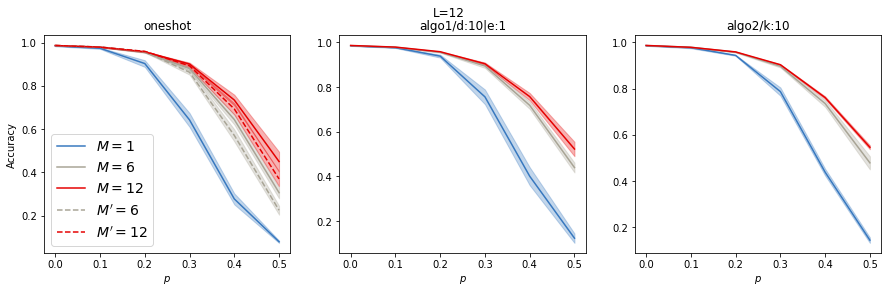

In [78]:
plot_robust_curve(df_mnist_256d, 12, ["oneshot", "algo1/d:10|e:1", "algo2/k:10"], df_vib=df_mnist_vib_256d)
plt.savefig("./figures/salt-pepper/mnist-l12.pdf")

## VIB 256

In [11]:
df_mnist_vib_256d = read_analysis_from_dir("../artifacts-server/hydra/experiment-mnist-256d-test-robustness-vib/*/*")
df_mnist_vib_256d.groupby(["strategy", "M", "L", "p"])["M"].count()

we have 12 analyses


strategy  M   L   p  
oneshot   6   1   0.0    4
                  0.1    4
                  0.2    4
                  0.3    4
                  0.4    4
                  0.5    4
              12  0.0    4
                  0.1    4
                  0.2    4
                  0.3    4
                  0.4    4
                  0.5    4
          12  1   0.0    4
                  0.1    4
                  0.2    4
                  0.3    4
                  0.4    4
                  0.5    4
              12  0.0    4
                  0.1    4
                  0.2    4
                  0.3    4
                  0.4    4
                  0.5    4
          18  1   0.0    4
                  0.1    4
                  0.2    4
                  0.3    4
                  0.4    4
                  0.5    4
              12  0.0    4
                  0.1    4
                  0.2    4
                  0.3    4
                  0.4    4
                  0.5    4
Name: 

In [248]:
print_table(df_mnist_vib_256d, 0.0, 12, should_print=True)

\begin{tabular}{rcccc}
\toprule
{} & \multicolumn{3}{l}{accuracy ($p=0.000000$, L=12)} \\
{} \\
M &                            6  &              12 &              18 \\
strategy &                               &                 &                 \\
\midrule
oneshot  &                98.63±0.0702\% &  98.68±0.0883\% &  98.72±0.0953\% \\
\bottomrule
\end{tabular}



/Users/heytitle/projects/venv-python3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


accuracy ($p=0.000000$, L=12)                                
                                                                      
M                                   6               12              18
strategy                                                              
oneshot                 98.63±0.0702\%  98.68±0.0883\%  98.72±0.0953\%

In [249]:
print_table(df_mnist_vib_256d, 0.1, 12, should_print=True)

\begin{tabular}{rcccc}
\toprule
{} & \multicolumn{3}{l}{accuracy ($p=0.100000$, L=12)} \\
{} \\
M &                            6  &              12 &              18 \\
strategy &                               &                 &                 \\
\midrule
oneshot  &                97.98±0.0964\% &  97.90±0.1486\% &  98.00±0.0726\% \\
\bottomrule
\end{tabular}



/Users/heytitle/projects/venv-python3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


accuracy ($p=0.100000$, L=12)                                
                                                                      
M                                   6               12              18
strategy                                                              
oneshot                 97.98±0.0964\%  97.90±0.1486\%  98.00±0.0726\%

In [250]:
print_table(df_mnist_vib_256d, 0.2, 12, should_print=True)

\begin{tabular}{rcccc}
\toprule
{} & \multicolumn{3}{l}{accuracy ($p=0.200000$, L=12)} \\
{} \\
M &                            6  &              12 &              18 \\
strategy &                               &                 &                 \\
\midrule
oneshot  &                95.80±0.2287\% &  95.94±0.2482\% &  96.04±0.1517\% \\
\bottomrule
\end{tabular}



/Users/heytitle/projects/venv-python3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


accuracy ($p=0.200000$, L=12)                                
                                                                      
M                                   6               12              18
strategy                                                              
oneshot                 95.80±0.2287\%  95.94±0.2482\%  96.04±0.1517\%

In [251]:
print_table(df_mnist_vib_256d, 0.3, 12, should_print=True)

\begin{tabular}{rcccc}
\toprule
{} & \multicolumn{3}{l}{accuracy ($p=0.300000$, L=12)} \\
{} \\
M &                            6  &              12 &              18 \\
strategy &                               &                 &                 \\
\midrule
oneshot  &                86.28±1.1099\% &  89.26±0.8507\% &  90.81±0.3708\% \\
\bottomrule
\end{tabular}



/Users/heytitle/projects/venv-python3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


accuracy ($p=0.300000$, L=12)                                
                                                                      
M                                   6               12              18
strategy                                                              
oneshot                 86.28±1.1099\%  89.26±0.8507\%  90.81±0.3708\%

In [252]:
print_table(df_mnist_vib_256d, 0.4, 12, should_print=True)

\begin{tabular}{rcccc}
\toprule
{} & \multicolumn{3}{l}{accuracy ($p=0.400000$, L=12)} \\
{} \\
M &                            6  &              12 &              18 \\
strategy &                               &                 &                 \\
\midrule
oneshot  &                57.10±2.7686\% &  69.33±2.5932\% &  76.84±1.5443\% \\
\bottomrule
\end{tabular}



/Users/heytitle/projects/venv-python3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


accuracy ($p=0.400000$, L=12)                                
                                                                      
M                                   6               12              18
strategy                                                              
oneshot                 57.10±2.7686\%  69.33±2.5932\%  76.84±1.5443\%

In [253]:
print_table(df_mnist_vib_256d, 0.5, 12, should_print=True)

\begin{tabular}{rcccc}
\toprule
{} & \multicolumn{3}{l}{accuracy ($p=0.500000$, L=12)} \\
{} \\
M &                            6  &              12 &              18 \\
strategy &                               &                 &                 \\
\midrule
oneshot  &                22.51±2.0573\% &  36.97±3.3367\% &  48.17±2.6505\% \\
\bottomrule
\end{tabular}



/Users/heytitle/projects/venv-python3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


accuracy ($p=0.500000$, L=12)                                
                                                                      
M                                   6               12              18
strategy                                                              
oneshot                 22.51±2.0573\%  36.97±3.3367\%  48.17±2.6505\%

## VDB 2D

In [272]:
df_mnist_2d = read_analysis_from_dir("../artifacts-server/hydra/experiment-mnist-2d-test-robustness/*/*")
df_mnist_2d.groupby(["strategy", "M", "L", "p"])["M"].count()

we have 21 analyses


strategy        M   L   p  
algo1/d:10|e:1  1   1   0.0    1
                        0.1    1
                        0.2    1
                        0.3    1
                        0.4    1
                        0.5    1
                    12  0.0    1
                        0.1    1
                        0.2    1
                        0.3    1
                        0.4    1
                        0.5    1
                6   1   0.0    1
                        0.1    1
                        0.2    1
                        0.3    1
                        0.4    1
                        0.5    1
                    12  0.0    1
                        0.1    1
                        0.2    1
                        0.3    1
                        0.4    1
                        0.5    1
                12  1   0.0    1
                        0.1    1
                        0.2    1
                        0.3    1
                        0.4    1
               

In [278]:
print_table(df_mnist_2d, 0.0, 12, should_print=True)

\begin{tabular}{rcccc}
\toprule
{} & \multicolumn{3}{l}{accuracy ($p=0.000000$, L=12)} \\
{} \\
M &                            1  &           6  &           12 \\
strategy       &                               &              &              \\
\midrule
algo1/d:10|e:1 &                   97.59±nan\% &  97.46±nan\% &  97.34±nan\% \\
algo1/d:20|e:1 &                   97.62±nan\% &  97.28±nan\% &  97.17±nan\% \\
algo1/d:5|e:1  &                   97.10±nan\% &  97.12±nan\% &  97.61±nan\% \\
algo2/k:10     &                   97.65±nan\% &  97.41±nan\% &  97.15±nan\% \\
algo2/k:20     &                   97.17±nan\% &  97.48±nan\% &  97.31±nan\% \\
algo2/k:5      &                   97.81±nan\% &  98.05±nan\% &  97.39±nan\% \\
oneshot        &                   97.69±nan\% &  97.24±nan\% &  97.56±nan\% \\
\bottomrule
\end{tabular}



/Users/heytitle/projects/venv-python3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


accuracy ($p=0.000000$, L=12)                          
                                                                      
M                                         1            6            12
strategy                                                              
algo1/d:10|e:1                   97.59±nan\%  97.46±nan\%  97.34±nan\%
algo1/d:20|e:1                   97.62±nan\%  97.28±nan\%  97.17±nan\%
algo1/d:5|e:1                    97.10±nan\%  97.12±nan\%  97.61±nan\%
algo2/k:10                       97.65±nan\%  97.41±nan\%  97.15±nan\%
algo2/k:20                       97.17±nan\%  97.48±nan\%  97.31±nan\%
algo2/k:5                        97.81±nan\%  98.05±nan\%  97.39±nan\%
oneshot                          97.69±nan\%  97.24±nan\%  97.56±nan\%

In [279]:
print_table(df_mnist_2d, 0.1, 12, should_print=True)

\begin{tabular}{rcccc}
\toprule
{} & \multicolumn{3}{l}{accuracy ($p=0.100000$, L=12)} \\
{} \\
M &                            1  &           6  &           12 \\
strategy       &                               &              &              \\
\midrule
algo1/d:10|e:1 &                   95.69±nan\% &  95.59±nan\% &  95.47±nan\% \\
algo1/d:20|e:1 &                   95.67±nan\% &  95.32±nan\% &  95.33±nan\% \\
algo1/d:5|e:1  &                   95.00±nan\% &  95.03±nan\% &  95.95±nan\% \\
algo2/k:10     &                   95.62±nan\% &  95.37±nan\% &  94.89±nan\% \\
algo2/k:20     &                   95.27±nan\% &  95.61±nan\% &  94.72±nan\% \\
algo2/k:5      &                   95.65±nan\% &  95.87±nan\% &  95.28±nan\% \\
oneshot        &                   95.35±nan\% &  94.38±nan\% &  95.38±nan\% \\
\bottomrule
\end{tabular}



/Users/heytitle/projects/venv-python3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


accuracy ($p=0.100000$, L=12)                          
                                                                      
M                                         1            6            12
strategy                                                              
algo1/d:10|e:1                   95.69±nan\%  95.59±nan\%  95.47±nan\%
algo1/d:20|e:1                   95.67±nan\%  95.32±nan\%  95.33±nan\%
algo1/d:5|e:1                    95.00±nan\%  95.03±nan\%  95.95±nan\%
algo2/k:10                       95.62±nan\%  95.37±nan\%  94.89±nan\%
algo2/k:20                       95.27±nan\%  95.61±nan\%  94.72±nan\%
algo2/k:5                        95.65±nan\%  95.87±nan\%  95.28±nan\%
oneshot                          95.35±nan\%  94.38±nan\%  95.38±nan\%

In [280]:
print_table(df_mnist_2d, 0.4, 12, should_print=True)

\begin{tabular}{rcccc}
\toprule
{} & \multicolumn{3}{l}{accuracy ($p=0.400000$, L=12)} \\
{} \\
M &                            1  &           6  &           12 \\
strategy       &                               &              &              \\
\midrule
algo1/d:10|e:1 &                   65.09±nan\% &  69.17±nan\% &  62.09±nan\% \\
algo1/d:20|e:1 &                   61.96±nan\% &  68.75±nan\% &  60.08±nan\% \\
algo1/d:5|e:1  &                   66.06±nan\% &  62.85±nan\% &  64.28±nan\% \\
algo2/k:10     &                   66.02±nan\% &  60.19±nan\% &  57.84±nan\% \\
algo2/k:20     &                   62.48±nan\% &  65.77±nan\% &  58.46±nan\% \\
algo2/k:5      &                   59.23±nan\% &  56.48±nan\% &  62.53±nan\% \\
oneshot        &                   59.75±nan\% &  44.34±nan\% &  56.26±nan\% \\
\bottomrule
\end{tabular}



/Users/heytitle/projects/venv-python3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


accuracy ($p=0.400000$, L=12)                          
                                                                      
M                                         1            6            12
strategy                                                              
algo1/d:10|e:1                   65.09±nan\%  69.17±nan\%  62.09±nan\%
algo1/d:20|e:1                   61.96±nan\%  68.75±nan\%  60.08±nan\%
algo1/d:5|e:1                    66.06±nan\%  62.85±nan\%  64.28±nan\%
algo2/k:10                       66.02±nan\%  60.19±nan\%  57.84±nan\%
algo2/k:20                       62.48±nan\%  65.77±nan\%  58.46±nan\%
algo2/k:5                        59.23±nan\%  56.48±nan\%  62.53±nan\%
oneshot                          59.75±nan\%  44.34±nan\%  56.26±nan\%

In [281]:
print_table(df_mnist_2d, 0.5, 12, should_print=True)

\begin{tabular}{rcccc}
\toprule
{} & \multicolumn{3}{l}{accuracy ($p=0.500000$, L=12)} \\
{} \\
M &                            1  &           6  &           12 \\
strategy       &                               &              &              \\
\midrule
algo1/d:10|e:1 &                   44.62±nan\% &  48.41±nan\% &  42.77±nan\% \\
algo1/d:20|e:1 &                   42.92±nan\% &  50.97±nan\% &  43.00±nan\% \\
algo1/d:5|e:1  &                   48.64±nan\% &  45.37±nan\% &  46.24±nan\% \\
algo2/k:10     &                   46.72±nan\% &  41.01±nan\% &  38.97±nan\% \\
algo2/k:20     &                   43.87±nan\% &  47.80±nan\% &  35.85±nan\% \\
algo2/k:5      &                   38.09±nan\% &  36.11±nan\% &  42.65±nan\% \\
oneshot        &                   38.47±nan\% &  28.36±nan\% &  37.24±nan\% \\
\bottomrule
\end{tabular}



/Users/heytitle/projects/venv-python3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


accuracy ($p=0.500000$, L=12)                          
                                                                      
M                                         1            6            12
strategy                                                              
algo1/d:10|e:1                   44.62±nan\%  48.41±nan\%  42.77±nan\%
algo1/d:20|e:1                   42.92±nan\%  50.97±nan\%  43.00±nan\%
algo1/d:5|e:1                    48.64±nan\%  45.37±nan\%  46.24±nan\%
algo2/k:10                       46.72±nan\%  41.01±nan\%  38.97±nan\%
algo2/k:20                       43.87±nan\%  47.80±nan\%  35.85±nan\%
algo2/k:5                        38.09±nan\%  36.11±nan\%  42.65±nan\%
oneshot                          38.47±nan\%  28.36±nan\%  37.24±nan\%

## VDB 21D

In [311]:
df_mnist_21d = read_analysis_from_dir("../artifacts-server/hydra/experiment-mnist-21d-test-robustness/*/*")
df_mnist_21d.groupby(["strategy", "M", "L", "p"])["M"].count()

we have 36 analyses


strategy        M   L   p  
algo1/d:10|e:1  1   1   0.0    4
                        0.1    4
                        0.2    4
                        0.3    4
                        0.4    4
                        0.5    4
                    12  0.0    4
                        0.1    4
                        0.2    4
                        0.3    4
                        0.4    4
                        0.5    4
                6   1   0.0    4
                        0.1    4
                        0.2    4
                        0.3    4
                        0.4    4
                        0.5    4
                    12  0.0    4
                        0.1    4
                        0.2    4
                        0.3    4
                        0.4    4
                        0.5    4
                12  1   0.0    4
                        0.1    4
                        0.2    4
                        0.3    4
                        0.4    4
               

In [312]:
print_table(df_mnist_21d, 0.0, 12, should_print=True)

\begin{tabular}{rcccc}
\toprule
{} & \multicolumn{3}{l}{accuracy ($p=0.000000$, L=12)} \\
{} \\
M &                            1  &              6  &              12 \\
strategy       &                               &                 &                 \\
\midrule
algo1/d:10|e:1 &                98.58±0.2285\% &  98.67±0.0310\% &  98.71±0.0975\% \\
algo2/k:10     &                98.74±0.0804\% &  98.73±0.0222\% &  97.86±1.7103\% \\
oneshot        &                98.62±0.0971\% &  98.58±0.3035\% &  98.73±0.0759\% \\
\bottomrule
\end{tabular}



/Users/heytitle/projects/venv-python3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


accuracy ($p=0.000000$, L=12)                                
                                                                            
M                                         1               6               12
strategy                                                                    
algo1/d:10|e:1                98.58±0.2285\%  98.67±0.0310\%  98.71±0.0975\%
algo2/k:10                    98.74±0.0804\%  98.73±0.0222\%  97.86±1.7103\%
oneshot                       98.62±0.0971\%  98.58±0.3035\%  98.73±0.0759\%

In [313]:
print_table(df_mnist_21d, 0.1, 12, should_print=True)

\begin{tabular}{rcccc}
\toprule
{} & \multicolumn{3}{l}{accuracy ($p=0.100000$, L=12)} \\
{} \\
M &                            1  &              6  &              12 \\
strategy       &                               &                 &                 \\
\midrule
algo1/d:10|e:1 &                97.73±0.4824\% &  97.92±0.1340\% &  97.80±0.2345\% \\
algo2/k:10     &                98.06±0.0983\% &  97.96±0.0594\% &  96.85±2.0084\% \\
oneshot        &                97.96±0.0592\% &  97.80±0.3426\% &  98.05±0.0714\% \\
\bottomrule
\end{tabular}



/Users/heytitle/projects/venv-python3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


accuracy ($p=0.100000$, L=12)                                
                                                                            
M                                         1               6               12
strategy                                                                    
algo1/d:10|e:1                97.73±0.4824\%  97.92±0.1340\%  97.80±0.2345\%
algo2/k:10                    98.06±0.0983\%  97.96±0.0594\%  96.85±2.0084\%
oneshot                       97.96±0.0592\%  97.80±0.3426\%  98.05±0.0714\%

In [314]:
print_table(df_mnist_21d, 0.4, 12, should_print=True)

\begin{tabular}{rcccc}
\toprule
{} & \multicolumn{3}{l}{accuracy ($p=0.400000$, L=12)} \\
{} \\
M &                            1  &              6  &              12 \\
strategy       &                               &                 &                 \\
\midrule
algo1/d:10|e:1 &                80.15±1.8838\% &  75.88±1.3019\% &  76.25±1.8423\% \\
algo2/k:10     &                80.50±0.2105\% &  76.74±0.9867\% &  76.64±1.9763\% \\
oneshot        &                75.99±1.8134\% &  80.71±1.8248\% &  78.44±0.7674\% \\
\bottomrule
\end{tabular}



/Users/heytitle/projects/venv-python3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


accuracy ($p=0.400000$, L=12)                                
                                                                            
M                                         1               6               12
strategy                                                                    
algo1/d:10|e:1                80.15±1.8838\%  75.88±1.3019\%  76.25±1.8423\%
algo2/k:10                    80.50±0.2105\%  76.74±0.9867\%  76.64±1.9763\%
oneshot                       75.99±1.8134\%  80.71±1.8248\%  78.44±0.7674\%

In [315]:
print_table(df_mnist_21d, 0.5, 12, should_print=True)

\begin{tabular}{rcccc}
\toprule
{} & \multicolumn{3}{l}{accuracy ($p=0.500000$, L=12)} \\
{} \\
M &                            1  &              6  &              12 \\
strategy       &                               &                 &                 \\
\midrule
algo1/d:10|e:1 &                64.00±1.3131\% &  56.76±2.1576\% &  57.65±3.0095\% \\
algo2/k:10     &                63.51±0.6525\% &  58.54±1.9797\% &  58.78±5.2182\% \\
oneshot        &                51.87±1.3668\% &  64.29±3.9257\% &  58.71±1.7387\% \\
\bottomrule
\end{tabular}



/Users/heytitle/projects/venv-python3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


accuracy ($p=0.500000$, L=12)                                
                                                                            
M                                         1               6               12
strategy                                                                    
algo1/d:10|e:1                64.00±1.3131\%  56.76±2.1576\%  57.65±3.0095\%
algo2/k:10                    63.51±0.6525\%  58.54±1.9797\%  58.78±5.2182\%
oneshot                       51.87±1.3668\%  64.29±3.9257\%  58.71±1.7387\%

## VIB 21D

In [321]:
df_mnist_21d_vib = read_analysis_from_dir("../artifacts-server/hydra/experiment-mnist-21d-test-robustness-vib/*/*")
df_mnist_21d_vib.groupby(["strategy", "M", "L", "p"])["M"].count()

we have 8 analyses


strategy  M   L   p  
oneshot   6   1   0.0    4
                  0.1    4
                  0.2    4
                  0.3    4
                  0.4    4
                  0.5    4
              12  0.0    4
                  0.1    4
                  0.2    4
                  0.3    4
                  0.4    4
                  0.5    4
          12  1   0.0    4
                  0.1    4
                  0.2    4
                  0.3    4
                  0.4    4
                  0.5    4
              12  0.0    4
                  0.1    4
                  0.2    4
                  0.3    4
                  0.4    4
                  0.5    4
Name: M, dtype: int64

In [322]:
print_table(df_mnist_21d_vib, 0.0, 12, should_print=True)

\begin{tabular}{rcccc}
\toprule
{} & \multicolumn{2}{l}{accuracy ($p=0.000000$, L=12)} \\
{} \\
M &                            6  &              12 \\
strategy &                               &                 \\
\midrule
oneshot  &                98.74±0.0789\% &  98.72±0.1034\% \\
\bottomrule
\end{tabular}



/Users/heytitle/projects/venv-python3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


accuracy ($p=0.000000$, L=12)                
                                                      
M                                   6               12
strategy                                              
oneshot                 98.74±0.0789\%  98.72±0.1034\%

In [323]:
print_table(df_mnist_21d_vib, 0.1, 12, should_print=True)

\begin{tabular}{rcccc}
\toprule
{} & \multicolumn{2}{l}{accuracy ($p=0.100000$, L=12)} \\
{} \\
M &                            6  &              12 \\
strategy &                               &                 \\
\midrule
oneshot  &                98.08±0.0837\% &  97.99±0.2111\% \\
\bottomrule
\end{tabular}



/Users/heytitle/projects/venv-python3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


accuracy ($p=0.100000$, L=12)                
                                                      
M                                   6               12
strategy                                              
oneshot                 98.08±0.0837\%  97.99±0.2111\%

In [324]:
print_table(df_mnist_21d_vib, 0.4, 12, should_print=True)

\begin{tabular}{rcccc}
\toprule
{} & \multicolumn{2}{l}{accuracy ($p=0.400000$, L=12)} \\
{} \\
M &                            6  &              12 \\
strategy &                               &                 \\
\midrule
oneshot  &                81.95±0.4542\% &  80.75±1.2985\% \\
\bottomrule
\end{tabular}



/Users/heytitle/projects/venv-python3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


accuracy ($p=0.400000$, L=12)                
                                                      
M                                   6               12
strategy                                              
oneshot                 81.95±0.4542\%  80.75±1.2985\%

In [325]:
print_table(df_mnist_21d_vib, 0.5, 12, should_print=True)

\begin{tabular}{rcccc}
\toprule
{} & \multicolumn{2}{l}{accuracy ($p=0.500000$, L=12)} \\
{} \\
M &                            6  &              12 \\
strategy &                               &                 \\
\midrule
oneshot  &                65.58±1.1714\% &  65.06±2.4417\% \\
\bottomrule
\end{tabular}



/Users/heytitle/projects/venv-python3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


accuracy ($p=0.500000$, L=12)                
                                                      
M                                   6               12
strategy                                              
oneshot                 65.58±1.1714\%  65.06±2.4417\%

## VIB 2D

In [283]:
df_mnist_2d_vib = read_analysis_from_dir("../artifacts-server/hydra/experiment-mnist-2d-test-robustness-vib/*/*")
df_mnist_2d_vib.groupby(["strategy", "M", "L", "p"])["M"].count()

we have 2 analyses


strategy  M   L   p  
oneshot   6   1   0.0    1
                  0.1    1
                  0.2    1
                  0.3    1
                  0.4    1
                  0.5    1
              12  0.0    1
                  0.1    1
                  0.2    1
                  0.3    1
                  0.4    1
                  0.5    1
          12  1   0.0    1
                  0.1    1
                  0.2    1
                  0.3    1
                  0.4    1
                  0.5    1
              12  0.0    1
                  0.1    1
                  0.2    1
                  0.3    1
                  0.4    1
                  0.5    1
Name: M, dtype: int64

In [292]:
print_table(df_mnist_2d_vib, 0.0, 12, should_print=True)

\begin{tabular}{rcccc}
\toprule
{} & \multicolumn{2}{l}{accuracy ($p=0.000000$, L=12)} \\
{} \\
M &                            6  &           12 \\
strategy &                               &              \\
\midrule
oneshot  &                   97.74±nan\% &  97.19±nan\% \\
\bottomrule
\end{tabular}



/Users/heytitle/projects/venv-python3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


accuracy ($p=0.000000$, L=12)             
                                                   
M                                   6            12
strategy                                           
oneshot                    97.74±nan\%  97.19±nan\%

In [291]:
print_table(df_mnist_2d_vib, 0.1, 12, should_print=True)

\begin{tabular}{rcccc}
\toprule
{} & \multicolumn{2}{l}{accuracy ($p=0.100000$, L=12)} \\
{} \\
M &                            6  &           12 \\
strategy &                               &              \\
\midrule
oneshot  &                   95.64±nan\% &  94.70±nan\% \\
\bottomrule
\end{tabular}



/Users/heytitle/projects/venv-python3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


accuracy ($p=0.100000$, L=12)             
                                                   
M                                   6            12
strategy                                           
oneshot                    95.64±nan\%  94.70±nan\%

In [293]:
print_table(df_mnist_2d_vib, 0.4, 12, should_print=True)

\begin{tabular}{rcccc}
\toprule
{} & \multicolumn{2}{l}{accuracy ($p=0.400000$, L=12)} \\
{} \\
M &                            6  &           12 \\
strategy &                               &              \\
\midrule
oneshot  &                   53.92±nan\% &  53.54±nan\% \\
\bottomrule
\end{tabular}



/Users/heytitle/projects/venv-python3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


accuracy ($p=0.400000$, L=12)             
                                                   
M                                   6            12
strategy                                           
oneshot                    53.92±nan\%  53.54±nan\%

In [294]:
print_table(df_mnist_2d_vib, 0.5, 12, should_print=True)

\begin{tabular}{rcccc}
\toprule
{} & \multicolumn{2}{l}{accuracy ($p=0.500000$, L=12)} \\
{} \\
M &                            6  &           12 \\
strategy &                               &              \\
\midrule
oneshot  &                   34.08±nan\% &  33.30±nan\% \\
\bottomrule
\end{tabular}



/Users/heytitle/projects/venv-python3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


accuracy ($p=0.500000$, L=12)             
                                                   
M                                   6            12
strategy                                           
oneshot                    34.08±nan\%  33.30±nan\%

# FashionMNIST

## Resnet VDB

In [45]:
df_fashion_mnist_resnet = read_analysis_from_dir("../artifacts-server/mpg-server/experiment-robustness-fashion_mnist/*/resnet20-vdb*")
df_fashion_mnist_resnet.groupby(["strategy", "M", "p"])["M"].count()

we have 36 analyses


strategy        M   p  
algo1/d:10|e:1  1   0.0    8
                    0.1    8
                    0.2    8
                    0.3    8
                    0.4    8
                    0.5    8
                6   0.0    8
                    0.1    8
                    0.2    8
                    0.3    8
                    0.4    8
                    0.5    8
                12  0.0    8
                    0.1    8
                    0.2    8
                    0.3    8
                    0.4    8
                    0.5    8
algo2/k:10      1   0.0    8
                    0.1    8
                    0.2    8
                    0.3    8
                    0.4    8
                    0.5    8
                6   0.0    8
                    0.1    8
                    0.2    8
                    0.3    8
                    0.4    8
                    0.5    8
                12  0.0    8
                    0.1    8
                    0.2    8
                   

In [59]:
print_table(df_fashion_mnist_resnet, 0.3, 12, should_print=False)

/Users/heytitle/projects/venv-python3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/Users/heytitle/projects/venv-python3/lib/python3.7/site-packages/pandas/core/generic.py:3111: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


accuracy ($p=0.300000$, L=12)                                
                                                                            
M                                         1               6               12
strategy                                                                    
algo1/d:10|e:1                17.63±1.9634\%  15.07±2.0919\%  17.68±2.0679\%
algo2/k:10                    18.44±1.3849\%  17.26±3.3846\%  17.33±2.9685\%
oneshot                       14.82±2.1890\%  15.40±2.9948\%  18.96±0.7565\%

In [56]:
df_fashion_mnist_resnet_vib = read_analysis_from_dir("../artifacts-server/mpg-server/experiment-robustness-fashion_mnist-vib/*/resnet20-vib*")
df_fashion_mnist_resnet_vib
df_fashion_mnist_resnet_vib.groupby(["strategy", "M", "p"])["M"].count()

we have 8 analyses


strategy  M   p  
oneshot   6   0.0    8
              0.1    8
              0.2    8
              0.3    8
              0.4    8
              0.5    8
          12  0.0    8
              0.1    8
              0.2    8
              0.3    8
              0.4    8
              0.5    8
Name: M, dtype: int64

In [423]:
print_table(df_fashion_mnist_resnet_vib, 0.3, 12, should_print=True)

\begin{tabular}{rcccc}
\toprule
{} & \multicolumn{2}{l}{accuracy ($p=0.300000$, L=12)} \\
{} \\
M &                            6  &              12 \\
strategy &                               &                 \\
\midrule
oneshot  &                18.97±2.6524\% &  15.92±1.7400\% \\
\bottomrule
\end{tabular}



/Users/heytitle/projects/venv-python3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


accuracy ($p=0.300000$, L=12)                
                                                      
M                                   6               12
strategy                                              
oneshot                 18.97±2.6524\%  15.92±1.7400\%

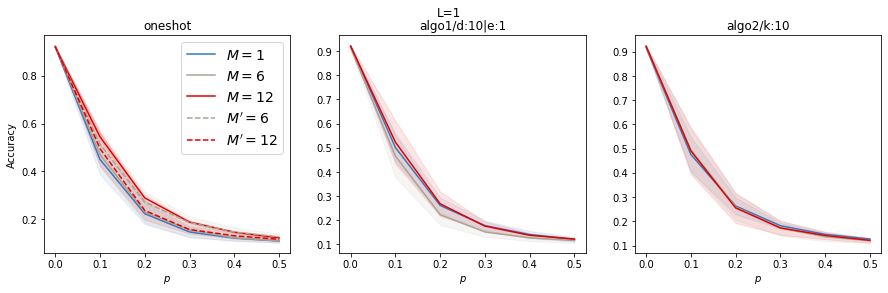

In [79]:
plot_robust_curve(
    df_fashion_mnist_resnet,
    1,
    ["oneshot", "algo1/d:10|e:1", "algo2/k:10"],
    alpha=0.1,
    df_vib=df_fashion_mnist_resnet_vib
)
plt.savefig("./figures/salt-pepper/fmnist-mnist-l1.pdf")

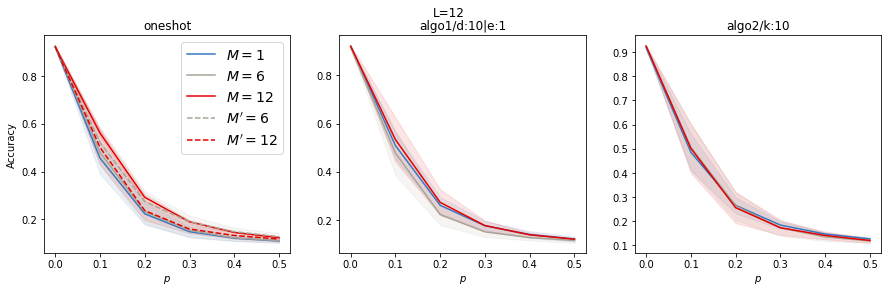

In [80]:
plot_robust_curve(
    df_fashion_mnist_resnet,
    12,
    ["oneshot", "algo1/d:10|e:1", "algo2/k:10"],
    alpha=0.1,
    df_vib=df_fashion_mnist_resnet_vib
)
plt.savefig("./figures/salt-pepper/fmnist-mnist-l12.pdf")

# CIFAR10

In [332]:

# df_cifar10_resnet = read_analysis_from_dir("../artifacts-server/mpg-server/experiment-cifar-256d-test-robustness/*/*")
# df_cifar10_resnet.groupby(["strategy", "M", "p"])["M"].count()

In [330]:
print_table(df_cifar10_resnet, 1, 0.0, should_print=False)

AttributeError: 'DataFrame' object has no attribute 'L'

In [328]:
print_table(df_cifar10_256d, 0.01,  1, should_print=False)

AttributeError: 'DataFrame' object has no attribute 'L'

In [171]:
print_table(df_cifar10_256d, 0.02, should_print=False)

/Users/heytitle/projects/venv-python3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


accuracy ($p=0.02$)                                
                                                                  
M                               1               6               12
strategy                                                          
algo1/d:10|e:1      18.26±3.2386\%     20.37±nan\%  19.14±0.7582\%
algo2/k:10          18.58±5.5854\%  18.14±2.5313\%  17.48±2.1879\%
oneshot             17.90±2.8195\%  18.58±2.4899\%  17.85±2.8409\%

In [178]:
print_table(df_cifar10_256d, 0.05, should_print=False)

/Users/heytitle/projects/venv-python3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


accuracy ($p=0.050000$)                                
                                                                      
M                                   1               6               12
strategy                                                              
algo1/d:10|e:1          11.61±0.9550\%     11.81±nan\%  11.42±0.7592\%
algo2/k:10              11.76±1.2505\%  11.68±0.7819\%  11.06±0.5250\%
oneshot                 11.16±0.5499\%  11.91±1.0109\%  11.74±1.1096\%

In [179]:
print_table(df_cifar10_256d, 0.1, should_print=False)

/Users/heytitle/projects/venv-python3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


accuracy ($p=0.100000$)                                
                                                                      
M                                   1               6               12
strategy                                                              
algo1/d:10|e:1          10.73±0.4283\%     11.01±nan\%  10.59±0.4234\%
algo2/k:10              10.64±0.3669\%  10.65±0.3665\%  10.52±0.3217\%
oneshot                 10.43±0.2512\%  10.97±0.6971\%  10.80±0.6355\%

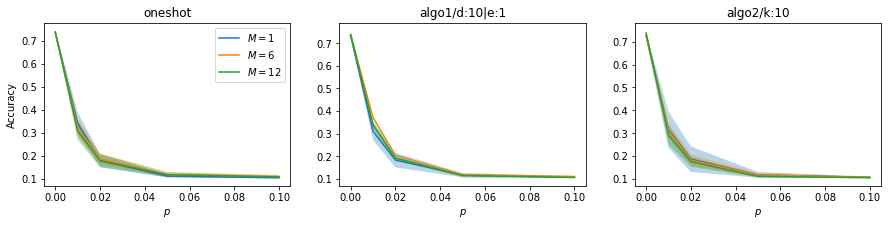

In [165]:
plot_robust_curve(df_cifar10_256d, ["oneshot", "algo1/d:10|e:1", "algo2/k:10"])